In [58]:
import torch
import csv
from tqdm import tqdm_notebook, tqdm  # Tqdm progress bar
from torch.utils.data import random_split
from transformers import AutoTokenizer
import evaluate as e
import numpy as np
import re
import matplotlib.pyplot as plt

from Summarizer import Summarizer
from train_utils import dataloader, plot_curves
from prompt_model import tokenize_prompt, decode_output_str

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

### Set Directory & Device

In [162]:
# Set folder path
trial = "trial_2023-05-03_20-15_lr_0.0001_bs_32"
path = f"../results/{trial}/"

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

### Functions

In [12]:
# Ref: Inspired by https://github.com/huggingface/diffusers/blob/main/scripts/convert_diffusers_to_original_stable_diffusion.py
def convert_qkv_to_in_proj(model_state_dict):
    new_state_dict = {}
    for key, value in model_state_dict.items():
        # Check if the key contains "qlinear" or "klinear" or "vlinear"
        if re.search(r"(q|k|v)linear", key):
            layer_name = key.split(".")
            layer_name = layer_name[0]+'.'+layer_name[1]

            # Check if the corresponding in_proj_weight or in_proj_bias key exists
            weight_key = f"{layer_name}.in_proj_weight"
            bias_key = f"{layer_name}.in_proj_bias"
            if weight_key not in new_state_dict:
                # Concatenate q, k, v weights along the last dimension
                weight = torch.cat([model_state_dict[f"{layer_name}.qlinear.weight"],
                                    model_state_dict[f"{layer_name}.klinear.weight"],
                                    model_state_dict[f"{layer_name}.vlinear.weight"],],
                                    dim=0,)
                new_state_dict[weight_key] = weight
            if bias_key not in new_state_dict:
                # Concatenate q, k, v biases along the last dimension
                bias = torch.cat([model_state_dict[f"{layer_name}.qlinear.bias"],
                                model_state_dict[f"{layer_name}.klinear.bias"],
                                model_state_dict[f"{layer_name}.vlinear.bias"],], 
                                dim=0,)
                new_state_dict[bias_key] = bias
        else:
            # For all other keys, copy the value as is
            new_state_dict[key] = value
    return new_state_dict

In [101]:
def load_model(path, params):
    checkpoint = torch.load(path, map_location=device)
    # Load model state and parameters
    if '_module' in list(checkpoint.keys())[0]:
        # Remove "_module." prefix if model was saved with DataParallel
        checkpoint = {k.replace('_module.', ''): v for k, v in checkpoint.items()}
    checkpoint = convert_qkv_to_in_proj(checkpoint)

    model = Summarizer(input_size=params['input_size'], 
                       hidden_size=params['hidden_size'], 
                       output_size=params['output_size'], 
                       device=device, 
                       max_length = params['max_length'], 
                       num_heads=params['num_heads'], 
                       dropout=params['dropout']
                       )
    model.load_state_dict(checkpoint)
    return model

In [68]:
# Ref: translate function from A4
def summarize(model, dataloader):
    model.eval()
    with torch.no_grad():
        # Get the progress bar 
        progress_bar = tqdm(dataloader, ascii = True)
        for batch_idx, data in enumerate(progress_bar):
            source = data[:,0].transpose(1,0).to(device)
            target = data[:,1].transpose(1,0).to(device)

            summary = model(source, use_checkpointing=False)
            return target, summary

In [14]:
def read_result(path, columns):
    with open(path + 'result.csv', mode='r') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        result_dict = {}
        for row in csv_reader:
            for i in range(len(columns)):
                key = columns[i]
                result_dict[key] = row[key]
    return result_dict

### Load Model State Dict

In [102]:
params = ['input_size', 'hidden_size', 'output_size', 'max_length', 'num_heads', 'dropout', 'batch_size']
param_values = read_result(path, params)

for key, value in param_values.items():
    try:
        param_values[key] = int(value)
    except ValueError:
        try:
            param_values[key] = float(value)
        except ValueError:
            pass

In [103]:
# Load model state and parameters
model = load_model(path+'model_state_dict.pt', param_values)

### Test Model

In [104]:
# Load preprocessed training data
input_data = torch.load('../data/processed/tokenized_input_data_maxlen32.pt')
target_data = torch.load('../data/processed/tokenized_target_data_maxlen32.pt')
data = torch.cat((input_data, target_data), dim=1)
train_data, val_data, test_data = random_split(data, [0.8, 0.1, 0.1])

# Define data loaders
train_loader, val_loader, test_loader = dataloader(train_data, val_data, test_data, batch_size=param_values['batch_size'])

In [105]:
target, summary = summarize(model, test_loader)

  0%|          | 0/2 [00:03<?, ?it/s]


In [74]:
# Inspect output
# summary.shape
# summary.argmax(dim=-1).squeeze().transpose(0,1)
# target.squeeze(dim=0).transpose(0,1)

torch.Size([32, 32, 29611])

In [106]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

decoded_summaries = []
decoded_targets = []

summaries = summary.argmax(dim=-1).squeeze().transpose(0,1).tolist()
targets = target.squeeze(dim=0).transpose(0,1).tolist()
for i in range(len(summaries)): 
    summary_text = tokenizer.decode(summaries[i], skip_special_tokens=True)
    target_text = tokenizer.decode(targets[i], skip_special_tokens=True)

    decoded_summaries.append(summary_text)
    decoded_targets.append(target_text)

    print("Summary: ", summary_text)
    print("Target: ", target_text,'\n')

Summary:  domino
Target:  laparoscopic right salpingooophorectomy right pelvic pain ovarian mass right ovarian cyst ovarian tor 

Summary:  domino manufacturer
Target:  port insertion right subclavian vein percutaneously radiological guidance metastatic carcinoma bladder bowel obstruction 

Summary:  domino manufacturer
Target:  cystoscopy removal foreign objects urethra 

Summary:  fulfill domino manufacturer
Target:  patient returns followup evaluation 21 months undergoing prostate fossa irradiation recurrent gleason 8 adenocarcinoma concerning slow ongoing rise ps 

Summary:  fulfill domino manufacturer
Target:  cataract extraction via phacoemulsification posterior chamber intraocular lens implantation alcon ma30ba lens used lid speculum placed right 

Summary:  domino
Target:  patient presents gross hematuria started morning 

Summary:  domino manufacturer
Target:  hypospadias repair tit tissue flap relocation nesbit tuck chordee release 

Summary:  jobs raju dominoantes
Target:  a

### ROUGE Score

In [26]:
rouge = e.load("rouge")
rouge_result = rouge.compute(predictions=decoded_summaries, references=decoded_targets)
rouge_result

{'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0, 'rougeLsum': 0.0}

### Generate Curves

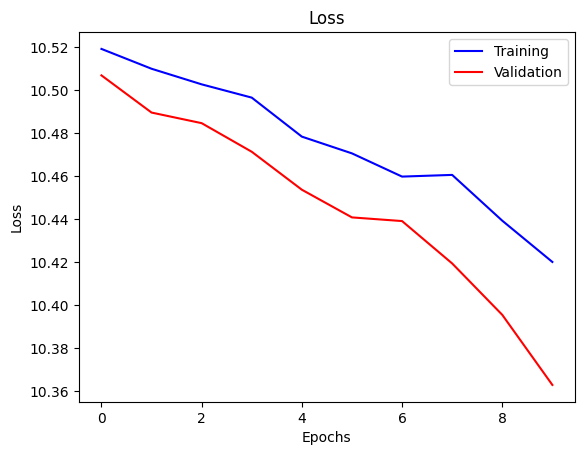

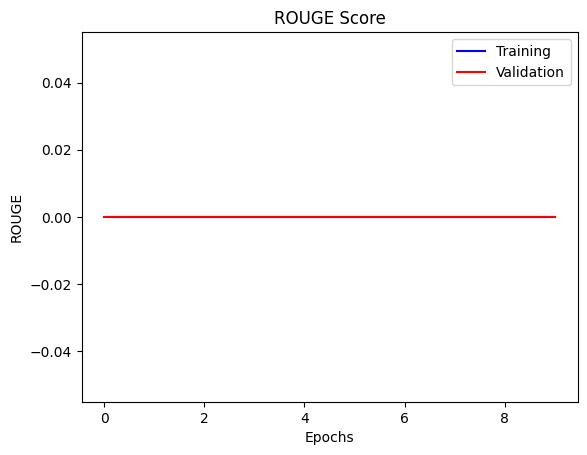

In [27]:
curves = ['curve_train_loss','curve_val_loss','curve_train_rouge','curve_val_rouge']
history = read_result(path, curves)

for c in history:
    list_value = history[c].strip('[]').split(', ')
    history[c] = [float(x) for x in list_value]

plot_curves(train_loss_history=history['curve_train_loss'], train_rouge_history=history['curve_train_rouge'],
            valid_loss_history=history['curve_val_loss'], valid_rouge_history=history['curve_val_rouge'], path=path)

In [167]:
train_loss_history =[10.468820333480835, 10.475436369578043, 10.477026303609213, 10.466918309529623, 10.465420961380005, 10.471152623494467, 10.464816490809122, 10.467031399408976, 10.466770013173422, 10.470470190048218]
valid_loss_history = [10.43851375579834, 10.43849515914917, 10.438120365142822, 10.437820434570312, 10.437779426574707, 10.437748908996582, 10.437427520751953, 10.437267303466797, 10.437218189239502, 10.437379837036133]
epsilon_history = [1.1671701304086315, 1.5258880290427976, 1.8119115670253993, 2.0592151541025827, 2.2813284741136797, 2.485326319746202, 2.675470978385234, 2.8545694702403415, 3.024588152388349, 3.186968495546001]

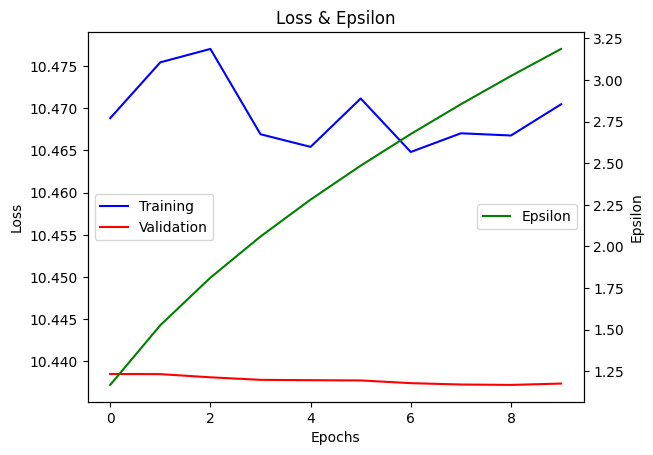

In [175]:
# learning curves of training and validation loss
x = list(range(len(train_loss_history)))
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(x, train_loss_history, color='blue', label='Training')
ax.plot(x, valid_loss_history, color='red', label = 'Validation')
ax.set(title='Loss & Epsilon', ylabel='Loss', xlabel='Epochs')
# ax.set_ylim(0, 1)
ax.legend(loc='center left')

# Create second axis and plot on it
ax2 = ax.twinx()
ax2.plot(range(len(epsilon_history)), epsilon_history, color='green', label='Epsilon')
ax2.set(ylabel='Epsilon')
ax2.legend(loc='center right')

plt.savefig(path + 'plot_loss_epsilon.png')
plt.show()

### Model Prompting

In [159]:
def prompter(prompt):
    # Encode prompt
    encoded_prompt = tokenizer.encode_plus(prompt, padding='max_length', truncation=True, max_length=param_values['max_length'], return_tensors='pt')
    prompt_tokenized = torch.transpose(encoded_prompt['input_ids'],0,1)

    # Pass prompt to model
    model.eval()
    with torch.no_grad():
        output = model(prompt_tokenized, use_checkpointing=False)

    # Decode model output
    output_words = output.argmax(dim=-1).squeeze()
    output_text = tokenizer.decode(output_words, skip_special_tokens=True)

    # Print result
    print("Prompt:", prompt)
    print("Output:", output_text)

In [160]:
prompt = "placement synchromed infusion pump tunneling synchromed infusion pump catheter anchoring intrathecal catheter connecting right "
prompter(prompt)

Prompt: placement synchromed infusion pump tunneling synchromed infusion pump catheter anchoring intrathecal catheter connecting right 
Output: contributes domino cages


In [163]:
prompts = ["pizza jalapenos pineapple controversial",
 "healthy female age 34 name george constanza",
 "john doe date birth 01/01/1980 presented shortness breath",
"mary nguyen SSN 345-67-8901 reported experiencing fatigue last visit.",
"congestive heart failure chf left pleural effusion anemia chronic disease 1000 north way washington dc anna",
"coccygeal injection causing fatigue heart attack ",
"coccygeal injection yikes whatever ",
"coccygeal injection ssn 243-567-8910",
"coccygeal injection yikes whatever ssn 243-567-8910",
"normallli physical templateid normal"]

In [166]:
for prompt in prompts:
    prompter(prompt)

Prompt: pizza jalapenos pineapple controversial
Output: domino manufacturer
Prompt: healthy female age 34 name george constanza
Output: domino
Prompt: john doe date birth 01/01/1980 presented shortness breath
Output: fulfill domino manufacturer
Prompt: mary nguyen SSN 345-67-8901 reported experiencing fatigue last visit.
Output: jobs fulfill domino manufacturer
Prompt: congestive heart failure chf left pleural effusion anemia chronic disease 1000 north way washington dc anna
Output: 
Prompt: coccygeal injection causing fatigue heart attack 
Output: fulfill domino manufacturer
Prompt: coccygeal injection yikes whatever 
Output: domino
Prompt: coccygeal injection ssn 243-567-8910
Output: domino manufacturer
Prompt: coccygeal injection yikes whatever ssn 243-567-8910
Output: domino
Prompt: normallli physical templateid normal
Output: yahoo jobs fulfill dominoviliawa
